# Clasificación del Rendimiento Académico con una Red Neuronal Simple

Entrenamos un modelo de red neuronal para clasificar el rendimiento académico de los estudiantes utilizando variables disponibles al momento de la matriculación. Partimos de una arquitectura de referencia inicial y analizamos su desempeño.

## 1. Carga y preparación del conjunto de datos

Utilizamos un conjunto de datos previamente procesado y balanceado (`data_resampled.csv`). La variable objetivo representa la clasificación del rendimiento académico. Aplicamos una división 80/20 entre entrenamiento y prueba, como en el resto de modelos.


In [416]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import random
# Fijamos la semilla para reproducibilidad
np.random.seed(42)
random.seed(42)

# Cargar datos
df = pd.read_csv('data_resampled.csv')

# Separar variables y etiquetas
X = df.drop(columns=['Target']).values
Y = df['Target'].values

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División entrenamiento/prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42, stratify=Y)

## 2. Definición del modelo

Definimos una red neuronal compuesta por una capa de entrada, dos capas ocultas con activación ReLU y una capa de salida con activación sigmoide.


In [417]:
import numpy as np
from scipy import stats

# Funciones de activación
sigmoid = (lambda x: 1 / (1 + np.exp(-x)), lambda x: x * (1 - x))
relu = (lambda x: x * (x > 0), lambda x: (x > 0).astype(float))

# Clase de capa
class Capa:
    def __init__(self, n_entradas, n_neuronas, funcion_act):
        self.funcion_act = funcion_act
        self.b = stats.truncnorm.rvs(-1, 1, loc=0, scale=1, size=(1, n_neuronas))
        self.W = stats.truncnorm.rvs(-1, 1, loc=0, scale=1, size=(n_entradas, n_neuronas))

# Arquitectura simple: entrada → 16 → 8 → 1
n_entradas = X.shape[1]
red_neuronal = [
    Capa(n_entradas, 16, relu),
    Capa(16, 8, relu),
    Capa(8, 1, sigmoid)
]

## 3. Entrenamiento del modelo

Entrenamos la red mediante descenso del gradiente y retropropagación del error. Utilizamos el error cuadrático medio (MSE) como función de coste.


In [418]:
def mse(Y_hat, Y):
    Y_hat = Y_hat.reshape(-1, 1)
    Y = Y.reshape(-1, 1)
    error = (Y_hat - Y)**2
    deriv = (Y_hat - Y)
    return error.mean(), deriv

def forward_pass(X, red_neuronal):
    output = [X]
    for capa in red_neuronal:
        z = output[-1] @ capa.W + capa.b
        a = capa.funcion_act[0](z)
        output.append(a)
    return output

def backpropagation(X, Y, red_neuronal, lr=0.01):
    salida = forward_pass(X, red_neuronal)
    delta = []
    for i in reversed(range(len(red_neuronal))):
        a = salida[i+1]
        if i == len(red_neuronal) - 1:
            err = mse(a, Y)[1] * red_neuronal[i].funcion_act[1](a)
        else:
            err = delta[-1] @ red_neuronal[i+1].W.T * red_neuronal[i].funcion_act[1](a)
        delta.append(err)
        red_neuronal[i].b -= lr * np.mean(err, axis=0, keepdims=True)
        red_neuronal[i].W -= lr * salida[i].T @ err
    return mse(salida[-1], Y)[0]

def predecir(X, red_neuronal):
    salida = forward_pass(X, red_neuronal)[-1]
    return (salida > 0.5).astype(int)

## 4. Evolución de las métricas durante el entrenamiento

Visualizamos la evolución de la pérdida y la precisión a lo largo de las épocas tanto en el conjunto de entrenamiento como en el de validación. Esto nos permite observar cómo progresa el aprendizaje del modelo y detectar posibles problemas de sobreajuste o falta de ajuste.


In [419]:
from sklearn.metrics import accuracy_score

# Inicializamos listas para guardar métricas
train_loss = []
val_loss = []
train_acc = []
val_acc = []

# Entrenamiento
for epoch in range(100):
    # Paso de entrenamiento
    error = backpropagation(X_train, Y_train, red_neuronal, lr=0.001)
    train_loss.append(error)

    Y_pred_train = predecir(X_train, red_neuronal)
    acc_train = accuracy_score(Y_train, Y_pred_train)
    train_acc.append(acc_train)

    # Evaluación en validación
    output_val = forward_pass(X_test, red_neuronal)[-1]
    val_error, _ = mse(output_val, Y_test)
    val_loss.append(val_error)

    Y_pred_test = (output_val > 0.5).astype(int)
    acc_test = accuracy_score(Y_test, Y_pred_test)
    val_acc.append(acc_test)

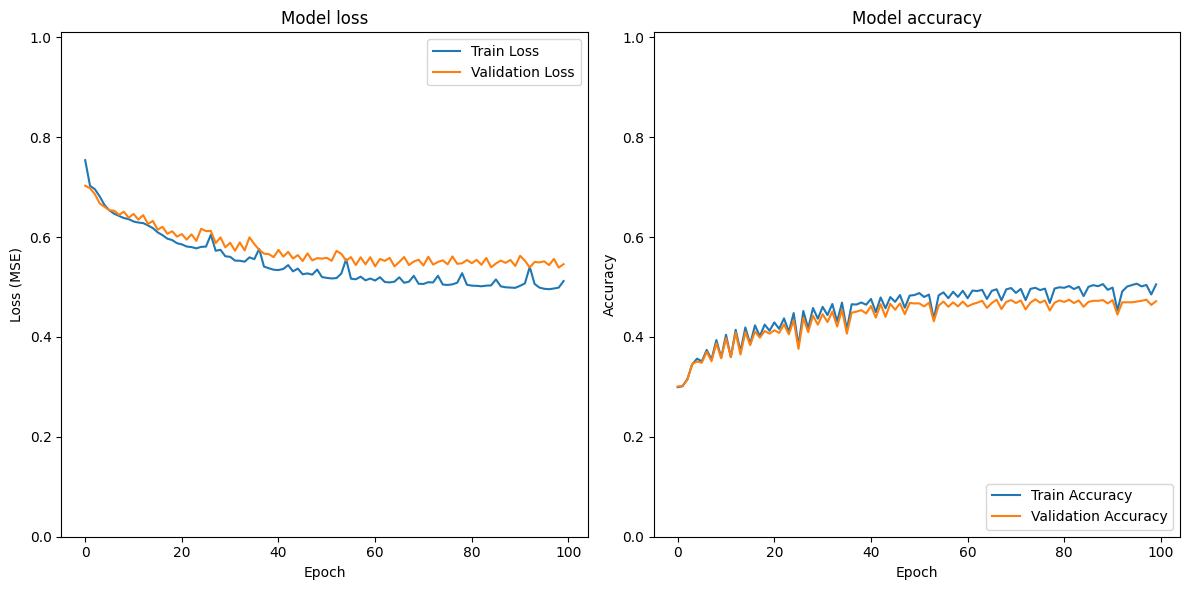

In [420]:

plt.figure(figsize=(12, 6))

# Gráfico de loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.ylim([0, 1.01])

# Gráfico de accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.ylim([0, 1.01])

plt.tight_layout()
plt.show()


## 5. Análisis de resultados del primer entrenamiento

A continuación, analizamos el comportamiento del modelo basándonos en las gráficas de pérdida y precisión registradas durante el entrenamiento y validación.

### Pérdida (Loss)
- Observamos una curva con forma logarítmica invertida, que se aproxima a los ejes pero ambas con muchos picos.
- Tanto en entrenamiento como en validación, la pérdida no desciende de forma suave, sino con oscilaciones significativas en múltiples puntos.
- Con el avance de las épocas, la pérdida de entrenamiento continúa bajando de manera más consistente que la de validación, generando una separación visible entre ambas.

### Precisión (Accuracy)
- Ambas curvas presentan una tendencia ascendente, pero con gran variabilidad.
- La precisión de entrenamiento tiende hacia valores cercanos a 0.5, mientras que la precisión en validación permanece más cercana a 0.4.
- La separación progresiva entre ambas curvas refuerza la presencia de un posible sobreajuste.

### Principales observaciones
1. **Presencia de picos**: Las oscilaciones abruptas en las métricas indican inestabilidad durante el entrenamiento.

2. **Posible sobreajuste**: La creciente separación entre las métricas de entrenamiento y validación sugiere que el modelo está capturando patrones específicos del conjunto de entrenamiento sin generalizar bien.

A continuación, vamos a probar una nueva ejecución reduciendo el parámetro `learning_rate`, con el objetivo de abordar los problemas observados en la estabilidad y generalización del modelo.

## 6. Análisis del entrenamiento con tasa de aprendizaje 0.0001

Volvemos a entrenar el modelo utilizando exactamente la misma arquitectura, pero con un valor reducido para el parámetro `learning_rate`, ajustado ahora a `0.0001`. Este cambio busca reducir la inestabilidad observada previamente y permitir que la red ajuste sus parámetros con mayor suavidad.

A continuación, observamos la evolución de la pérdida y la precisión tanto en entrenamiento como en validación.

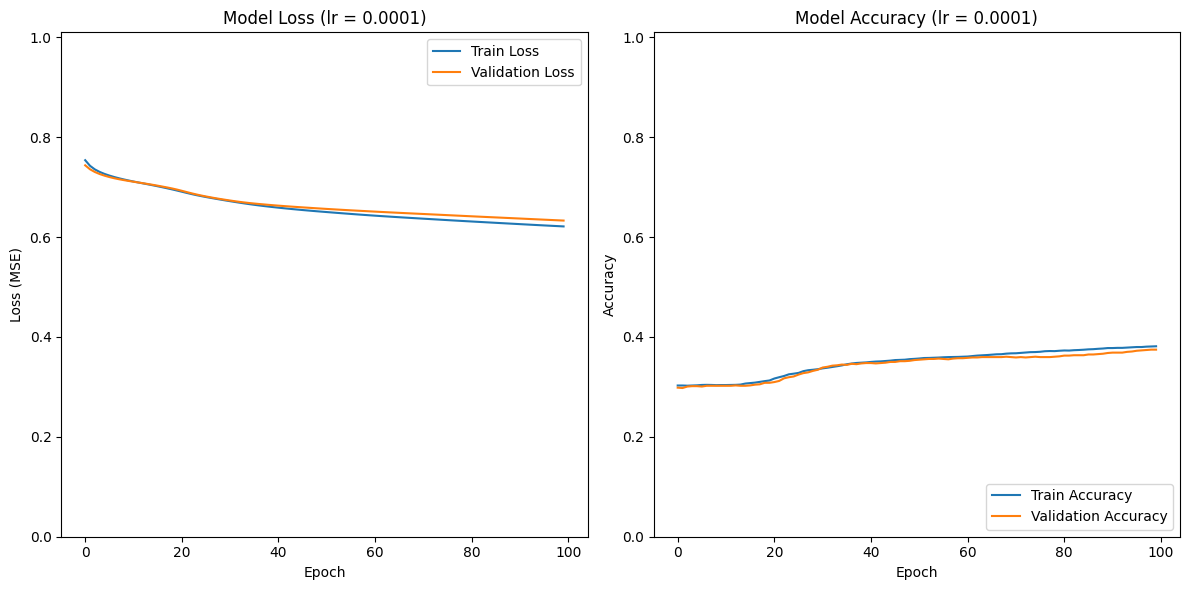

In [421]:
# Redefinimos la red neuronal con pesos reinicializados
np.random.seed(42)

n_entradas = X.shape[1]
red_neuronal = [
    Capa(n_entradas, 16, relu),
    Capa(16, 8, relu),
    Capa(8, 1, sigmoid)
]

# Entrenamiento con learning rate bajo
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(100):
    # Paso de entrenamiento
    error = backpropagation(X_train, Y_train, red_neuronal, lr=0.0001)
    train_loss.append(error)

    Y_pred_train = predecir(X_train, red_neuronal)
    acc_train = accuracy_score(Y_train, Y_pred_train)
    train_acc.append(acc_train)

    # Evaluación en validación
    output_val = forward_pass(X_test, red_neuronal)[-1]
    val_error, _ = mse(output_val, Y_test)
    val_loss.append(val_error)

    Y_pred_test = (output_val > 0.5).astype(int)
    acc_test = accuracy_score(Y_test, Y_pred_test)
    val_acc.append(acc_test)

# Visualización
plt.figure(figsize=(12, 6))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss (lr = 0.0001)')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.ylim([0, 1.01])

# Precisión
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy (lr = 0.0001)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.ylim([0, 1.01])

plt.tight_layout()
plt.show()


## 7. Comparación y evaluación del nuevo entrenamiento

Tras reducir la tasa de aprendizaje a `0.0001`, observamos mejoras claras en relación con los dos problemas detectados en la configuración anterior:

### 1. Generalización del modelo
Las curvas de pérdida y precisión correspondientes al conjunto de entrenamiento y al de validación se mantienen muy próximas durante todo el proceso. Esta alineación sugiere que el modelo ha logrado generalizar correctamente, sin sobreajustarse a los datos de entrenamiento.

### 2. Estabilidad del entrenamiento
La evolución de las métricas es mucho más suave. Las oscilaciones abruptas que aparecían anteriormente han desaparecido, lo que permite una lectura más clara y consistente del comportamiento del modelo.

### 3. Precisión final
Sin embargo, ahora la precisión alcanzada ha disminuido ligeramente (por debajo de 0.4 en ambas curvas). Esta se mantiene estable y coherente entre entrenamiento y validación, lo cual refuerza la idea de una mejor capacidad de generalización, aunque esta no sea muy buena.

### 4. Comportamiento de las curvas
Ambas métricas muestran una tendencia a estabilizarse de forma temprana. Las mejoras entre épocas son mínimas a partir de cierto punto, lo que sugiere que el modelo converge de forma rápida con este valor de tasa de aprendizaje.

Este comportamiento abre la puerta a posibles optimizaciones:
- Podríamos reducir el número de épocas sin afectar la precisión final.
- También podríamos ajustar el tamaño de lote (por ejemplo, `batch_size = 50`) para acelerar el proceso de entrenamiento, especialmente útil en modelos más complejos o con mayor volumen de datos.

En conjunto, esta configuración proporciona un punto de partida más equilibrado entre estabilidad, capacidad de generalización y eficiencia computacional.


## 8. Entrenamiento con un modelo más complejo (Keras)

Una vez ajustado el modelo simple mediante la modificación de la tasa de aprendizaje, vamos a explorar una arquitectura más compleja utilizando Keras y TensorFlow. Dado que el modelo anterior no ha alcanzado niveles satisfactorios de precisión, consideramos razonable aumentar la capacidad de la red para evaluar si una estructura más profunda permite obtener mejores resultados.

En esta nueva configuración, implementamos una red neuronal con tres capas ocultas, cada una compuesta por 128 neuronas y activadas mediante la función ReLU. Esta arquitectura incrementa significativamente la complejidad del modelo, lo que podría permitir capturar patrones más sofisticados en los datos.


### Preparación de datos para Keras

In [422]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Codificamos el target como one-hot
encoder = OneHotEncoder(sparse_output=False)
Y_encoded = encoder.fit_transform(Y.reshape(-1, 1))

# División del dataset (ya está hecho antes, pero lo rehacemos con Y codificado)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_encoded,
    test_size=0.2,
    stratify=Y,
    random_state=42
)

### Definición y entrenamiento del modelo Keras

In [423]:
# Definición del modelo Keras
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],), kernel_initializer='he_normal'),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dense(3, activation='softmax')
])

# Compilación del modelo
model.compile(
    optimizer=Adam(learning_rate=0.000001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=5,
    validation_data=(X_test, Y_test)
)

c:\Users\humbe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3761 - loss: 21.5073 - val_accuracy: 0.3731 - val_loss: 10.4329
Epoch 2/50
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3596 - loss: 7.0251 - val_accuracy: 0.3254 - val_loss: 2.3828
Epoch 3/50
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3197 - loss: 2.1642 - val_accuracy: 0.3687 - val_loss: 2.0055
Epoch 4/50
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3607 - loss: 1.8843 - val_accuracy: 0.3933 - val_loss: 1.8508
Epoch 5/50
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3942 - loss: 1.7302 - val_accuracy: 0.4157 - val_loss: 1.7192
Epoch 6/50
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4330 - loss: 1.6007 - val_accuracy: 0.4537 - val_loss: 1.6081
Epoch 7/50
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4592 - loss: 1.4810 - val_accuracy: 0.4851 - val_loss: 1.5279
Epoch 8/50
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5035 - loss: 1.4081 

### Visualización del rendimiento del modelo complejo

A continuación, representamos gráficamente la evolución de la pérdida y la precisión durante el entrenamiento y la validación.

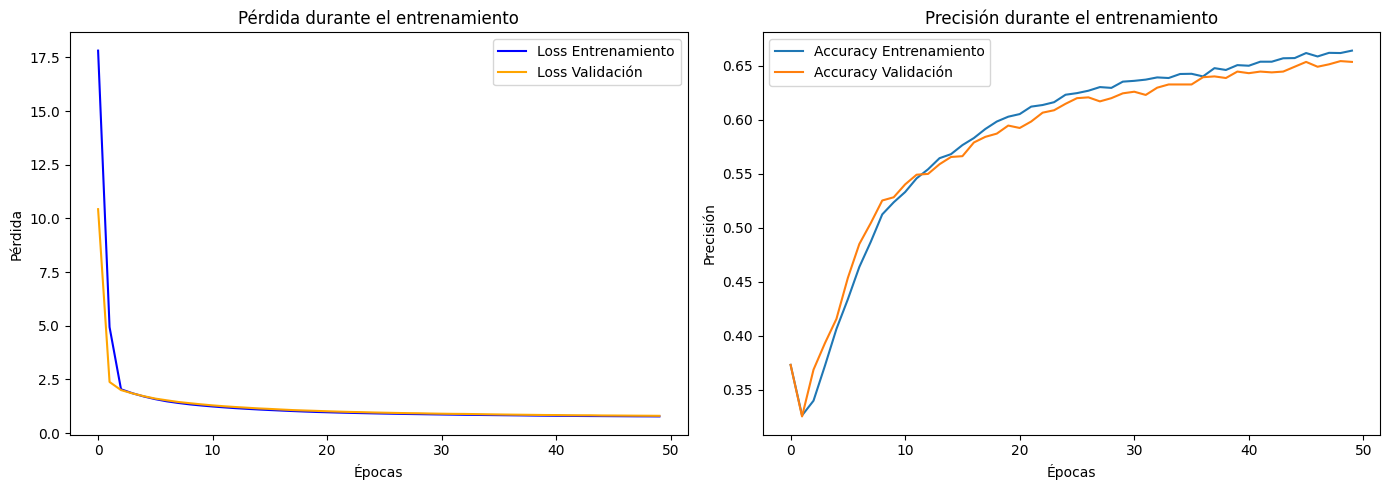

In [426]:
plt.figure(figsize=(14, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss Entrenamiento', color='blue')
plt.plot(history.history['val_loss'], label='Loss Validación', color='orange')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()


plt.tight_layout()
plt.show()

## 9. Evaluación del modelo complejo

Al analizar los resultados obtenidos con la red neuronal implementada en Keras, observamos una mejora significativa en comparación con los modelos anteriores: la precisión ha alcanzado un valor aproximado de 0.65.

Sin embargo, aunque este incremento representa un avance notable, no podemos considerar que el modelo sea adecuado para una aplicación práctica. A pesar de no presentar signos de sobreajuste —como se refleja en las curvas de pérdida, donde las métricas de entrenamiento y validación prácticamente se solapan—, el nivel de precisión sigue siendo insuficiente para generar predicciones fiables o justificar decisiones basadas en sus salidas.

Este resultado nos permite destacar un concepto esencial: **la ausencia de overfitting no implica que el modelo sea bueno**. La capacidad de generalizar es una condición necesaria, pero no suficiente. Un modelo que no está sobreentrenado puede, sin embargo, carecer de la estructura o expresividad necesarias para capturar patrones relevantes dentro de los datos.

En este caso concreto, a pesar de haber incrementado la complejidad de la arquitectura, el modelo no ha logrado representar adecuadamente la lógica subyacente del problema. Esto indica que es necesario seguir explorando otras opciones.